# NHANES age prediction.csv

## Data Preprocessing (NHANES age prediction.csv)

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score #sklearn for ROC only
import random
!pip install ucimlrepo

random.seed(110)
np.random.seed(110)

In [116]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset = fetch_ucirepo(id=887)

# data (as pandas dataframes)
X = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.features
y = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.targets

# metadata
print(national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.metadata)

# variable information
print(national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.variables)
y

{'uci_id': 887, 'name': 'National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset', 'repository_url': 'https://archive.ics.uci.edu/dataset/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset', 'data_url': 'https://archive.ics.uci.edu/static/public/887/data.csv', 'abstract': "The National Health and Nutrition Examination Survey (NHANES), administered by the Centers for Disease Control and Prevention (CDC), collects extensive health and nutritional information from a diverse U.S. population. Though expansive, the dataset is often too broad for specific analytical purposes. In this sub-dataset, we narrow our focus to predicting respondents' age by extracting a subset of features from the larger NHANES dataset. These selected features include physiological measurements, lifestyle choices, and biochemical markers, which were hypothesized to have strong correlations with age.", 'area': 'Health and Medicine', 'tasks': ['Classifi

,age_group
0,Adult
1,Adult
2,Adult
3,Adult
4,Adult
...,...
2273,Adult
2274,Adult
2275,Adult
2276,Adult


Check for missing values

In [117]:
X.isna().sum()

RIAGENDR    0
PAQ605      0
BMXBMI      0
LBXGLU      0
DIQ010      0
LBXGLT      0
LBXIN       0
dtype: int64

Calculate means of features by age group

In [118]:
senior_group = X[y['age_group'] == 'Senior']
adult_group = X[y['age_group'] == 'Adult']

senior_means = senior_group.mean()
print("Senior means:\n", senior_means)
adult_means = adult_group.mean()
print("\nAdult means:\n", adult_means)

Senior means:
 RIAGENDR      1.508242
PAQ605        1.909341
BMXBMI       27.886264
LBXGLU      104.329670
DIQ010        2.027473
LBXGLT      141.208791
LBXIN        10.405247
dtype: float64

Adult means:
 RIAGENDR      1.512017
PAQ605        1.806165
BMXBMI       27.968286
LBXGLU       98.644723
DIQ010        2.014107
LBXGLT      109.990596
LBXIN        12.106661
dtype: float64


In [119]:
squared_diff = (senior_means - adult_means) ** 2
ranked_features = squared_diff.sort_values(ascending=False)
print("\nRanked features based on squared difference:\n", ranked_features)


Ranked features based on squared difference:
 LBXGLT      974.575736
LBXGLU       32.318625
LBXIN         2.894810
PAQ605        0.010645
BMXBMI        0.006728
DIQ010        0.000179
RIAGENDR      0.000014
dtype: float64


1.   LBXGLT has a significant difference
2.   LBXGLU also shows a notable difference
3.   LBXIN shows a small difference between groups

The rest of the features have relatively small squared differences, which indicates that there is less variation between Adult and Senior groups for these variables.






### Data Split

NHANES age prediction

In [120]:
age_pred = pd.concat([X, y], axis=1)
age_pred_shuffled = age_pred.sample(frac=1, random_state = 110)

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

train_num = int(len(age_pred_shuffled) * train_ratio)
validation_num = int(len(age_pred_shuffled) * validation_ratio)

train = age_pred_shuffled[:train_num]
validation = age_pred_shuffled[train_num:train_num + validation_num]
test = age_pred_shuffled[train_num + validation_num:]

print("Training Set:", train.shape)
print("Validation Set:", validation.shape)
print("Test Set:", test.shape)

#relevant_columns = ['LBXGLT', 'LBXGLU', 'LBXIN']

train_x = train.values
train_y = train['age_group'].values

validation_x = validation.values
validation_y = validation['age_group'].values

test_x = test.values
test_y = test['age_group'].values

Training Set: (1366, 8)
Validation Set: (455, 8)
Test Set: (457, 8)


In [121]:
age_pred['age_group'] = age_pred['age_group'].astype('category').cat.codes

correlation_matrix = age_pred.corr()
correlation_matrix

,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
RIAGENDR,1.000000,0.151076,0.063873,-0.132342,-0.032769,0.017406,-0.016660,-0.002767
PAQ605,0.151076,1.000000,-0.042935,-0.007849,-0.002599,0.060413,0.010011,0.094789
BMXBMI,0.063873,-0.042935,1.000000,0.208330,0.047133,0.193375,0.552717,-0.004147
LBXGLU,-0.132342,-0.007849,0.208330,1.000000,-0.004427,0.685579,0.211911,0.116462
DIQ010,-0.032769,-0.002599,0.047133,-0.004427,1.000000,0.009796,0.058986,0.026399
LBXGLT,0.017406,0.060413,0.193375,0.685579,0.009796,1.000000,0.217272,0.243113
LBXIN,-0.016660,0.010011,0.552717,0.211911,0.058986,0.217272,1.000000,-0.064159
age_group,-0.002767,0.094789,-0.004147,0.116462,0.026399,0.243113,-0.064159,1.000000


## KNN class

In [122]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
class KNN:

  def __init__(self, K = 1, dist_fn = euclidean):
    self.dist_fn = dist_fn
    self.K = K


  def fit(self, x, y):
    self.x = x
    self.y = y
    self.C = np.max(y) + 1
    return self

  def predict(self, x_test):
    num_test = x_test.shape[0]
    distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
    knns = np.zeros((num_test, self.K), dtype=int)
    y_prob = np.zeros((num_test, self.C))
    for i in range(num_test):
            #print(i)
            knns[i,:] = np.argsort(distances[i])[:self.K]
            #print(knns[i,:])
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C)
    y_prob /= self.K
    return y_prob, knns

def evaluate_acc(y_true, y_pred):
  correct_pred = np.sum(y_true == y_pred)
  total_pred = len(y_true)
  acc = correct_pred / total_pred
  return acc


## DT & Node class


In [123]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node

def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]

            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value
  #computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [124]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination

    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels) + 1
        #below are initialization of the root of the decision tree
        self.root = Node(np.arange(data.shape[0]), None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        #to recursively build the rest of the tree
        self._fit_tree(self.root)
        return self

    def _fit_tree(self, node):
      #This gives the condition for termination of the recursion resulting in a leaf node
      if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
          return
      #greedily select the best test by minimizing the cost
      cost, split_feature, split_value = greedy_test(node, self.cost_fn)
      #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
      if np.isinf(cost):
          return
      #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
      #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
      test = node.data[node.data_indices,split_feature] <= split_value
      #store the split feature and value of the node
      node.split_feature = split_feature
      node.split_value = split_value
      #define new nodes which are going to be the left and right child of the present node
      left = Node(node.data_indices[test], node)
      right = Node(node.data_indices[np.logical_not(test)], node)
      #recursive call to the _fit_tree()
      self._fit_tree(left)
      self._fit_tree(right)
      #assign the left and right child to present child
      node.left = left
      node.right = right

    def predict(self, data_test):
      class_probs = np.zeros((data_test.shape[0], self.num_classes))
      for n, x in enumerate(data_test):
          node = self.root
          #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
          while node.left:
              if x[node.split_feature] <= node.split_value:
                  node = node.left
              else:
                  node = node.right
          #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
          class_probs[n,:] = node.class_prob
      return class_probs

DT on NHANES age prediction.csv

In [125]:
label_to_int = {'Adult': 0, 'Senior': 1}

def encode_labels(labels):
    encoded_labels = []
    for label in labels:
        encoded_label = label_to_int[label]
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

train_x = train.iloc[:, :-1].values
train_y = train.iloc[:, -1].values

test_x = test.iloc[:, :-1].values
test_y = test.iloc[:, -1].values

train_y_encoded = encode_labels(train_y)
test_y_encoded = encode_labels(test_y)

dt = DecisionTree(max_depth=3, num_classes=2)
dt.fit(train_x, train_y_encoded)

y_test_pred_probs = dt.predict(test_x)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

accuracy = evaluate_acc(test_y_encoded, y_test_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 83.15%


Choosing best depth and cost

In [126]:
validation_x = validation.iloc[:, :-1].values
validation_y = validation.iloc[:, -1].values
validation_y_encoded = encode_labels(validation_y)

model_choices = []
valid_acc = []
cost_functions = {
    'entropy': cost_entropy,
    'gini_index': cost_gini_index
}

for depth in range(1, 11):
    for cost_name, cost_fn in cost_functions.items():
        dt = DecisionTree(max_depth=depth, num_classes=2, cost_fn=cost_fn)
        dt.fit(train_x, train_y_encoded)

        y_valid_pred_probs = dt.predict(validation_x)
        y_valid_pred = np.argmax(y_valid_pred_probs, axis=1)

        accuracy = evaluate_acc(validation_y_encoded, y_valid_pred)

        if not valid_acc or accuracy > max(valid_acc):
            best_cost_fn = cost_name
            best_max_depth = depth

        model_choices.append((depth, cost_name))
        valid_acc.append(accuracy)

print(f"Best max_depth found: {best_max_depth} with Cost Function: {best_cost_fn}, Validation Accuracy: {max(valid_acc) * 100:.2f}%")

dt_best = DecisionTree(max_depth=best_max_depth, num_classes=2, cost_fn=cost_functions[best_cost_fn])
dt_best.fit(train_x, train_y_encoded)

y_test_pred_probs = dt_best.predict(test_x)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
test_accuracy = np.sum(y_test_pred == test_y_encoded) / len(test_y_encoded)
print(f"Test Accuracy with best max_depth = {best_max_depth} and Cost Function: {best_cost_fn}: {test_accuracy * 100:.2f}%")

Best max_depth found: 1 with Cost Function: entropy, Validation Accuracy: 86.15%
Test Accuracy with best max_depth = 1 and Cost Function: entropy: 83.15%


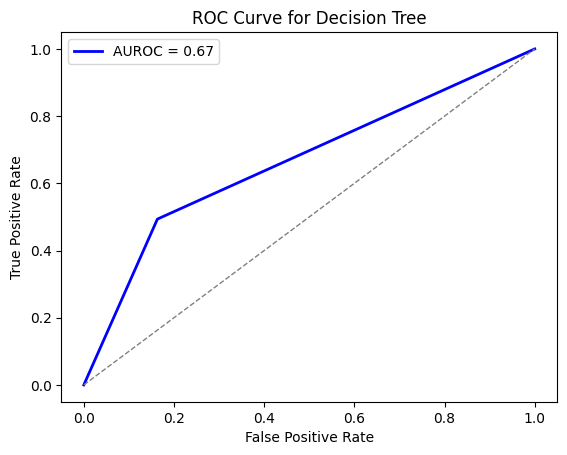

In [127]:
y_test_pred_probs = dt_best.predict(test_x)

y_test_proba = y_test_pred_probs[:, 1]

fpr_d, tpr_d, thresholds_d = roc_curve(test_y_encoded, y_test_proba)
roc_auc_d = roc_auc_score(test_y_encoded, y_test_proba)

plt.figure()
plt.plot(fpr_d, tpr_d, "b-", lw=2, label="AUROC = %0.2f" % roc_auc_d)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc="best")
plt.savefig("roc_curve_decision_tree_best_depth.png", bbox_inches='tight', dpi=300)
plt.show()

## KNN on NHANES age prediction.csv

Testing on k = 1

In [128]:
myK = 1
model = KNN(K=myK)
label_to_int = {'Adult': 0, 'Senior': 1}

def encode_labels(labels):
    encoded_labels = []
    for label in labels:
        encoded_label = label_to_int[label]
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

train_y_encoded = encode_labels(train['age_group'])
test_y_encoded = encode_labels(test['age_group'])
validation_y_encoded = encode_labels(validation['age_group'])

# relevant features that demonstrate the biggest mean squared difference
relevant_columns = ['LBXGLT', 'LBXGLU', 'PAQ605']
#relevant_columns = train.columns[:-1]

model.fit(train[relevant_columns].values, train_y_encoded)
y_prob, knns = model.predict(test[relevant_columns].values)

y_pred = np.argmax(y_prob, axis=-1)
accuracy = evaluate_acc(test_y_encoded, y_pred)
print(f'Accuracy is {accuracy * 100:.2f}%.')

Accuracy is 74.84%.


### Choosing hyperparameter K in KNN

In [129]:
model_choices = []
valid_acc = []

distance_functions = {'euclidean': euclidean, 'manhattan': manhattan}

for k in range(1, 11):
    for dist_name, dist_fn in distance_functions.items():
        knn = KNN(K=k, dist_fn=dist_fn)
        knn.fit(train[relevant_columns].values, train_y_encoded)
        y_valid_prob, _ = knn.predict(validation[relevant_columns].values)
        y_valid_pred = np.argmax(y_valid_prob, axis=1)
        accuracy = evaluate_acc(validation_y_encoded, y_valid_pred)

        if not valid_acc or accuracy > max(valid_acc):
            best_distance_fn = dist_name
            best_valid_K = k

        model_choices.append((k, dist_name))
        valid_acc.append(accuracy)

print(f"Best K found: {best_valid_K} with Distance Function: {best_distance_fn}, Validation Accuracy: {max(valid_acc) * 100:.2f}%")

knn_best = KNN(K=best_valid_K, dist_fn=distance_functions[best_distance_fn])
knn_best.fit(train[relevant_columns].values, train_y_encoded)

y_test_prob, _ = knn_best.predict(test[relevant_columns].values)
y_test_pred = np.argmax(y_test_prob, axis=1)
test_accuracy = evaluate_acc(test_y_encoded, y_test_pred)
print(f"Test Accuracy with best K = {best_valid_K} and Distance Function: {best_distance_fn}: {test_accuracy * 100:.2f}%")

Best K found: 6 with Distance Function: manhattan, Validation Accuracy: 86.37%
Test Accuracy with best K = 6 and Distance Function: manhattan: 82.06%


### ROC (NHANES age prediction.csv)

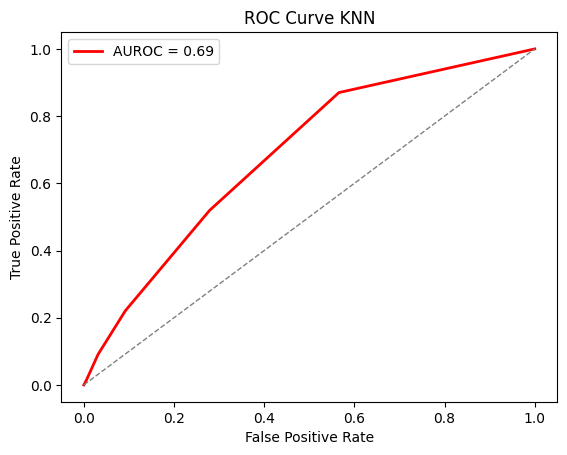

In [130]:
y_test_proba = y_test_prob[:, 1]

fpr_k, tpr_k, thresholds_k = roc_curve(test_y_encoded, y_test_proba)
roc_auc_k = roc_auc_score(test_y_encoded, y_test_proba)

plt.figure()
plt.plot(fpr_k, tpr_k, "r-", lw=2, label="AUROC = %0.2f" % roc_auc_k)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve KNN')
plt.legend(loc="best")
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)

ROC combined

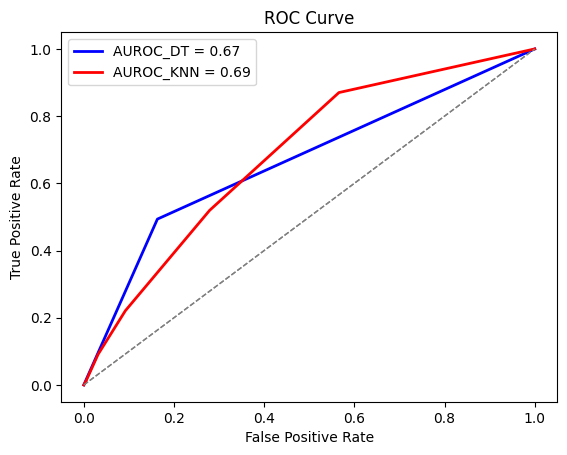

In [131]:
plt.figure()
plt.plot(fpr_d, tpr_d, "b-", lw=2, label="AUROC_DT = %0.2f" % roc_auc_d)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")

plt.plot(fpr_k, tpr_k, "r-", lw=2, label="AUROC_KNN = %0.2f" % roc_auc_k)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
plt.savefig("roc_curve_decision_tree_best_depth.png", bbox_inches='tight', dpi=300)
plt.show()

# Breast Cancer Wisconsin

## Data Preprocessing (Breast Cancer Wisconsin)

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score #sklearn for ROC only
import random
from ucimlrepo import fetch_ucirepo


In [133]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_original.data.features
y = breast_cancer_wisconsin_original.data.targets

# metadata
print(breast_cancer_wisconsin_original.metadata)

# variable information
print(breast_cancer_wisconsin_original.variables)

{'uci_id': 15, 'name': 'Breast Cancer Wisconsin (Original)', 'repository_url': 'https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original', 'data_url': 'https://archive.ics.uci.edu/static/public/15/data.csv', 'abstract': 'Original Wisconsin Breast Cancer Database', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 699, 'num_features': 9, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Class'], 'index_col': ['Sample_code_number'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1990, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5HP4Z', 'creators': ['WIlliam Wolberg'], 'intro_paper': None, 'additional_info': {'summary': "Samples arrive periodically as Dr. Wolberg reports his clinical cases. The database therefore reflects this chronological grouping of the data. This grouping information appears immediately below, having been removed fro

Check for missing values

In [134]:
X.isnull().sum()

Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    16
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
dtype: int64

Drop missing values

In [135]:
br_cancer = pd.concat([X, y], axis=1)
br_cancer_shuffled = br_cancer.sample(frac=1, random_state = 110)
br_cancer_shuffled = br_cancer_shuffled.dropna()

Calculate means of features by class

In [136]:
benign_group = X[y['Class'] == 2]
malignant_group = X[y['Class'] == 4]

benign_means = benign_group.mean()
print("Benign means:\n", benign_means)
malignant_means = malignant_group.mean()
print("\nMalignant means:\n", malignant_means)

Benign means:
 Clump_thickness                2.956332
Uniformity_of_cell_size        1.325328
Uniformity_of_cell_shape       1.443231
Marginal_adhesion              1.364629
Single_epithelial_cell_size    2.120087
Bare_nuclei                    1.346847
Bland_chromatin                2.100437
Normal_nucleoli                1.290393
Mitoses                        1.063319
dtype: float64

Malignant means:
 Clump_thickness                7.195021
Uniformity_of_cell_size        6.572614
Uniformity_of_cell_shape       6.560166
Marginal_adhesion              5.547718
Single_epithelial_cell_size    5.298755
Bare_nuclei                    7.627615
Bland_chromatin                5.979253
Normal_nucleoli                5.863071
Mitoses                        2.589212
dtype: float64


In [137]:
squared_diff = (benign_means - malignant_means) ** 2
ranked_features = squared_diff.sort_values(ascending=False)
print("\nRanked features based on squared difference:\n", ranked_features)


Ranked features based on squared difference:
 Bare_nuclei                    39.448049
Uniformity_of_cell_size        27.534017
Uniformity_of_cell_shape       26.183019
Normal_nucleoli                20.909380
Clump_thickness                17.966483
Marginal_adhesion              17.498234
Bland_chromatin                15.045217
Single_epithelial_cell_size    10.103929
Mitoses                         2.328349
dtype: float64


###Data split

In [138]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

train_num = int(len(br_cancer_shuffled) * train_ratio)
validation_num = int(len(br_cancer_shuffled) * validation_ratio)

train = br_cancer_shuffled[:train_num]
validation = br_cancer_shuffled[train_num:train_num + validation_num]
test = br_cancer_shuffled[train_num + validation_num:]

print("Training Set:", train.shape)
print("Validation Set:", validation.shape)
print("Test Set:", test.shape)

train_x = train.drop(columns=['Class']).values
train_y = train['Class'].values

validation_x = validation.drop(columns=['Class']).values
validation_y = validation['Class'].values

test_x = test.drop(columns=['Class']).values
test_y = test['Class'].values

# Encoding ensures that the current implementation of the KNN is treating labels
# as 2 classes and not 5
train_y_encoded = (train_y == 4).astype(int)
validation_y_encoded = (validation_y == 4).astype(int)
test_y_encoded = (test_y == 4).astype(int)

Training Set: (409, 10)
Validation Set: (136, 10)
Test Set: (138, 10)


## KNN on Breast Cancer Wisconsin

Testing on k = 1

In [139]:
myK = 1
model = KNN(K=myK)

model.fit(train_x, train_y_encoded)
y_prob, knns = model.predict(test_x)

y_pred = np.argmax(y_prob, axis=-1)
accuracy = evaluate_acc(test_y_encoded, y_pred)
print(f'Accuracy is {accuracy * 100:.2f}%.')

Accuracy is 96.38%.


### Choosing hyperparameter K in KNN

In [140]:
model_choices = []
valid_acc = []
best_distance_fn = None

distance_functions = [euclidean, manhattan]
distance_function_names = ['euclidean', 'manhattan']

for k in range(1, 11):
    for dist_fn, dist_name in zip(distance_functions, distance_function_names):
        knn = KNN(K=k, dist_fn=dist_fn)
        knn.fit(train_x, train_y_encoded)
        y_valid_prob, _ = knn.predict(validation_x)
        y_valid_pred = np.argmax(y_valid_prob, axis=1)
        accuracy = evaluate_acc(validation_y_encoded, y_valid_pred)

        if not valid_acc or accuracy > max(valid_acc):
            best_distance_fn = dist_name
            best_valid_K = k

        model_choices.append((k, dist_name))
        valid_acc.append(accuracy)

print(f"Best K found: {best_valid_K} with Distance Function: {best_distance_fn}, Validation Accuracy: {max(valid_acc) * 100:.2f}%")

knn_best = KNN(K=best_valid_K, dist_fn=distance_functions[distance_function_names.index(best_distance_fn)])
knn_best.fit(train_x, train_y_encoded)

y_test_prob, _ = knn_best.predict(test_x)
y_test_pred = np.argmax(y_test_prob, axis=1)
test_accuracy = evaluate_acc(test_y_encoded, y_test_pred)
print(f"Test Accuracy with best K = {best_valid_K} and Distance Function: {best_distance_fn}: {test_accuracy * 100:.2f}%")

Best K found: 9 with Distance Function: euclidean, Validation Accuracy: 97.79%
Test Accuracy with best K = 9 and Distance Function: euclidean: 95.65%


### ROC (Breast Cancer Wisconsin)

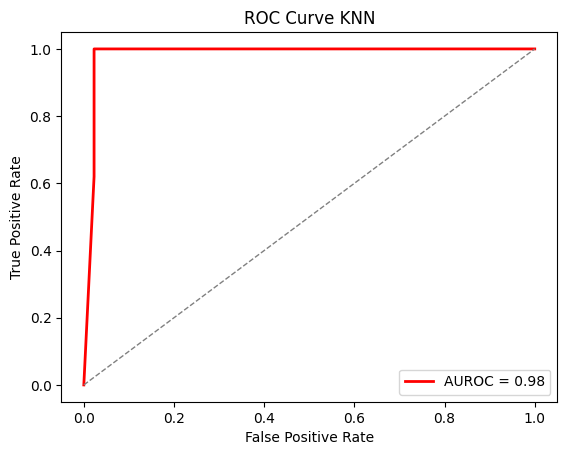

In [141]:
y_test_proba = y_test_prob[:, 1]

fpr_k, tpr_k, thresholds_k = roc_curve(test_y_encoded, y_test_proba)
roc_auc_k = roc_auc_score(test_y_encoded, y_test_proba)

plt.figure()
plt.plot(fpr_k, tpr_k, "r-", lw=2, label="AUROC = %0.2f" % roc_auc_k)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve KNN')
plt.legend(loc="best")
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
plt.show()


###DT on Breast Cancer Wisconsin

In [142]:
dt = DecisionTree(max_depth=3, num_classes=2)
dt.fit(train_x, train_y_encoded)

y_test_pred_probs = dt.predict(test_x)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

accuracy = evaluate_acc(test_y_encoded, y_test_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 95.65%


###Choosing depth and cost function

In [143]:
validation_x = validation.drop(columns=['Class']).values
validation_y = validation['Class'].values
validation_y_encoded = (validation_y == 4).astype(int)

model_choices = []
valid_acc = []
cost_functions = {
    'entropy': cost_entropy,
    'gini_index': cost_gini_index
}

for depth in range(1, 11):
    for cost_name, cost_fn in cost_functions.items():
        dt = DecisionTree(max_depth=depth, num_classes=2, cost_fn=cost_fn)
        dt.fit(train_x, train_y_encoded)

        y_valid_pred_probs = dt.predict(validation_x)
        y_valid_pred = np.argmax(y_valid_pred_probs, axis=1)

        accuracy = np.sum(y_valid_pred == validation_y_encoded) / len(validation_y_encoded)

        if not valid_acc or accuracy > max(valid_acc):
            best_cost_fn = cost_name
            best_max_depth = depth

        model_choices.append((depth, cost_name))
        valid_acc.append(accuracy)

print(f"Best max_depth found: {best_max_depth} with Cost Function: {best_cost_fn}, Validation Accuracy: {max(valid_acc) * 100:.2f}%")

dt_best = DecisionTree(max_depth=best_max_depth, num_classes=2, cost_fn=cost_functions[best_cost_fn])
dt_best.fit(train_x, train_y_encoded)

y_test_pred_probs = dt_best.predict(test_x)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
test_accuracy = np.sum(y_test_pred == test_y_encoded) / len(test_y_encoded)
print(f"Test Accuracy with best max_depth = {best_max_depth} and Cost Function: {best_cost_fn}: {test_accuracy * 100:.2f}%")

Best max_depth found: 3 with Cost Function: entropy, Validation Accuracy: 95.59%
Test Accuracy with best max_depth = 3 and Cost Function: entropy: 94.93%


## ROC

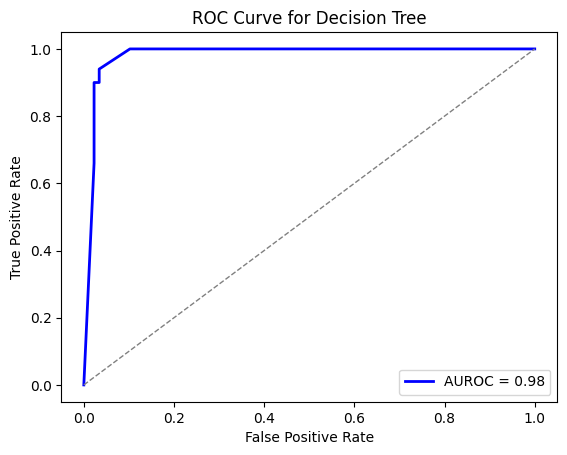

In [144]:
y_test_pred_probs = dt_best.predict(test_x)

y_test_proba = y_test_pred_probs[:, 1]

fpr_d, tpr_d, thresholds_d = roc_curve(test_y_encoded, y_test_proba)
roc_auc_d = roc_auc_score(test_y_encoded, y_test_proba)

plt.figure()
plt.plot(fpr_d, tpr_d, "b-", lw=2, label="AUROC = %0.2f" % roc_auc_d)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc="best")
plt.savefig("roc_curve_decision_tree.png", bbox_inches='tight', dpi=300)
plt.show()

###ROC combined

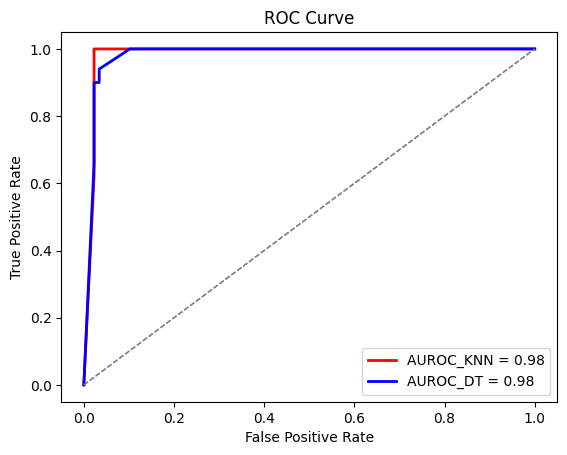

In [145]:
plt.figure()
plt.plot(fpr_k, tpr_k, "r-", lw=2, label="AUROC_KNN = %0.2f" % roc_auc_k)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)

plt.plot(fpr_d, tpr_d, "b-", lw=2, label="AUROC_DT = %0.2f" % roc_auc_d)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()